In [6]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import networkx as nx
from IPython.display import clear_output

sns.set_style(style="whitegrid")

In [7]:
def set_seed(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    if torch.backends.mps.is_available():
        torch.mps.manual_seed(seed)

seed = 1337
set_seed(seed)

In [8]:
import os
import sys

notebook_dir = os.getcwd()

root_dir = os.path.abspath(os.path.join(notebook_dir, "../../"))
sys.path.append(root_dir)

In [184]:
from dotenv import load_dotenv

load_dotenv()

from coral import DataSourceFactory
from core.models.datasource_type import DataSourceType
from core.models.protocol_type import ProtocolType
from service import EnvironmentSecretService

In [185]:
DEFAULT_DATASOUCE = DataSourceType.BYBIT
DEFAULT_SYMBOLS = ["1000PEPEUSDT"]
SLEEP_INTERVAL = 1
DOM = 10

In [186]:
datasource = DataSourceFactory(EnvironmentSecretService())
datasource.register_rest_exchange(DEFAULT_DATASOUCE)

ds = datasource.create(DEFAULT_DATASOUCE, ProtocolType.REST)

In [187]:
symbols = ds.fetch_future_symbols()
symbol = [symbol for symbol in symbols if symbol.name in DEFAULT_SYMBOLS]

In [188]:
def plot_order_book(bids, asks, highlight_best=True):
    bids_df = pd.DataFrame(bids, columns=['price', 'quantity'])
    asks_df = pd.DataFrame(asks, columns=['price', 'quantity'])

    bids_df = bids_df.sort_values(by='price', ascending=False)
    asks_df = asks_df.sort_values(by='price', ascending=True)

    bids_df['cum_quantity'] = bids_df['quantity'].cumsum()
    asks_df['cum_quantity'] = asks_df['quantity'].cumsum()

    clear_output(wait=True)

    plt.figure(figsize=(14, 9))

    sns.lineplot(x=bids_df['price'], y=bids_df['cum_quantity'], label='Bids', color='green', linewidth=2)
    sns.lineplot(x=asks_df['price'], y=asks_df['cum_quantity'], label='Asks', color='red', linewidth=2)

    bid_imbalance = bids_df['cum_quantity'].max() - asks_df['cum_quantity'].mean()
    ask_imbalance = asks_df['cum_quantity'].max() - bids_df['cum_quantity'].mean()
    imbalance_threshold = (bid_imbalance + ask_imbalance) / 2

    plt.axhline(imbalance_threshold, color='orange', linestyle='--', label=f'Imbalance Threshold: {imbalance_threshold:.2f}')

    plt.fill_between(bids_df['price'], bids_df['cum_quantity'], color='green', alpha=0.3, step='mid')
    plt.fill_between(asks_df['price'], asks_df['cum_quantity'], color='red', alpha=0.3, step='mid')

    if highlight_best:
        best_bid = bids_df['price'].iloc[0]
        best_ask = asks_df['price'].iloc[0]

        plt.axvline(best_bid, color='green', linestyle='--', label=f'Best Bid: {best_bid:.2f}', linewidth=1.5)
        plt.axvline(best_ask, color='red', linestyle='--', label=f'Best Ask: {best_ask:.2f}', linewidth=1.5)

        mid_price = (best_bid + best_ask) / 2
        plt.axvline(mid_price, color='blue', linestyle=':', label=f'Mid Price: {mid_price:.2f}', linewidth=1.5)

    vwap_bid = (bids_df['price'] * bids_df['quantity']).sum() / bids_df['quantity'].sum()
    vwap_ask = (asks_df['price'] * asks_df['quantity']).sum() / asks_df['quantity'].sum()

    plt.axvline(vwap_bid, color='darkgreen', linestyle=':', label=f'VWAP Bid: {vwap_bid:.2f}', linewidth=1.2)
    plt.axvline(vwap_ask, color='darkred', linestyle=':', label=f'VWAP Ask: {vwap_ask:.2f}', linewidth=1.2)

    plt.xlabel('Price', fontsize=12)
    plt.ylabel('Cumulative Quantity', fontsize=12)
    plt.title('Order Book Depth Chart', fontsize=14)

    plt.legend(loc="upper right")

    plt.show()

In [210]:
def plot_order_book(bids, asks):
    bids_df = pd.DataFrame(bids, columns=['price', 'quantity'])
    asks_df = pd.DataFrame(asks, columns=['price', 'quantity'])

    bids_df = bids_df.sort_values(by='price', ascending=False)
    asks_df = asks_df.sort_values(by='price', ascending=True)

    bids_df['cum_quantity'] = bids_df['quantity'].cumsum()
    asks_df['cum_quantity'] = asks_df['quantity'].cumsum()

    best_bid = bids_df['price'].iloc[0]
    best_ask = asks_df['price'].iloc[0]


    mid_price = (best_bid + best_ask) / 2

    spread = best_ask - best_bid
    mid_spread = spread / 2

    bids_df['relative_price'] = bids_df['price'] - best_bid - mid_spread
    asks_df['relative_price'] = asks_df['price'] - best_ask + mid_spread

    clear_output(wait=True)

    plt.figure(figsize=(14, 9))

    plt.bar(bids_df['relative_price'], -bids_df['cum_quantity'], color='green', label='Bids', width=spread/2, alpha=0.9)
    plt.bar(asks_df['relative_price'], asks_df['cum_quantity'], color='red', label='Asks', width=spread/2, alpha=0.9)

    plt.axvline(-mid_spread, color='green', linestyle='--', label=f'Best Bid: {best_bid:.2f}', linewidth=1.5)
    plt.axvline(0, color='blue', linestyle=':', label=f'Mid Price: {mid_price:.2f}', linewidth=1.5)
    plt.axvline(mid_spread, color='red', linestyle='--', label=f'Best Ask: {best_ask:.2f}', linewidth=1.5)

    plt.xlabel('Price Relative to Best Bid (Spread Divider)', fontsize=12)
    plt.ylabel('Cumulative Quantity (Depth)', fontsize=12)
    plt.title('Order Book Depth Bar Chart', fontsize=14)

    plt.legend(loc="upper right")
    plt.show()

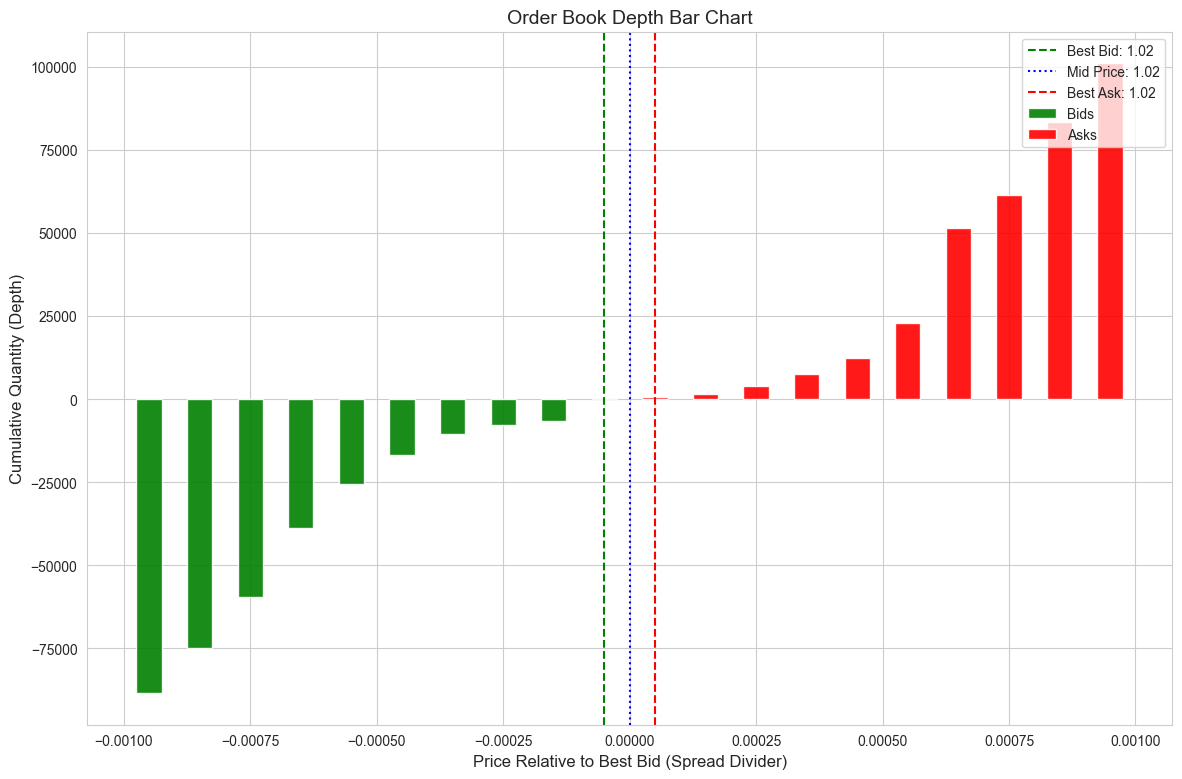

KeyboardInterrupt: 

In [211]:
while True:
    bids, asks, timestamp = ds.fetch_order_book(symbol[0], DOM)

    plot_order_book(np.array(bids), np.array(asks))

    time.sleep(SLEEP_INTERVAL)

In [34]:
def calculate_order_slices(symbol, total_size):
    x_min = symbol.min_position_size
    alpha = np.random.uniform(1.3, 1.5)

    while True:
        u = np.random.rand()

        order_size = x_min * (1 - u) ** (-1 / (alpha - 1))

        order_size = min(order_size, total_size)

        yield order_size

In [35]:
def plot_order_sizes(order_sizes):
    plt.figure(figsize=(10, 6))
    sns.histplot(order_sizes, bins=30, kde=False, color='blue', edgecolor='black', stat='density', alpha=0.6)
    plt.title('Distribution of Sampled Order Sizes')
    plt.xlabel('Order Size')
    plt.ylabel('Density')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

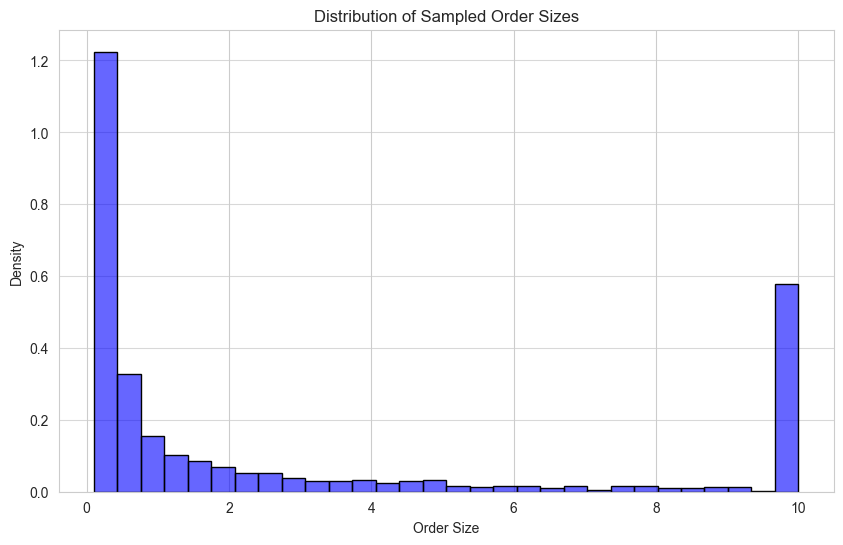

In [36]:
total_size = 10
num_samples = 1000

order_generator = calculate_order_slices(symbol=symbol[0], total_size=total_size)
order_sizes = [next(order_generator) for _ in range(num_samples)]

plot_order_sizes(order_sizes)


In [189]:
SLEEP_INTERVAL = 8
ONE_HOUR = 3600
MULTI = 8
ORDER_BOOK_FILE = f'order_book_{symbol[0].name}_8h.csv'

In [190]:
columns = ['timestamp'] + [item for i in range(1, DOM + 1) for item in [
    f'Ask {i} Price', 
    f'Ask {i} Size', 
    f'Bid {i} Price', 
    f'Bid {i} Size'
]]

df = pd.DataFrame(columns=columns)

start_time = time.time()
end_time = ONE_HOUR * MULTI

while True:
    bids, asks, timestamp = ds.fetch_order_book(symbol[0], DOM)

    row = [timestamp]

    for i in range(DOM):
        row.extend([asks[i][0], asks[i][1], bids[i][0], bids[i][1]])

    df.loc[len(df)] = row

    time.sleep(SLEEP_INTERVAL)
    
    if time.time() - start_time > end_time:
        break

df.to_csv(ORDER_BOOK_FILE, index=False)

df.head()

,timestamp,Ask 1 Price,Ask 1 Size,Bid 1 Price,Bid 1 Size,Ask 2 Price,Ask 2 Size,Bid 2 Price,Bid 2 Size,Ask 3 Price,...,Bid 8 Price,Bid 8 Size,Ask 9 Price,Ask 9 Size,Bid 9 Price,Bid 9 Size,Ask 10 Price,Ask 10 Size,Bid 10 Price,Bid 10 Size
0,1.730330e+12,0.009723,600.0,0.009723,183100.0,0.009723,600.0,0.009723,414300.0,0.009724,...,0.009722,60000.0,0.009725,1400.0,0.009722,60800.0,0.009725,4300.0,0.009721,78300.0
1,1.730330e+12,0.009723,600.0,0.009723,766900.0,0.009723,600.0,0.009723,44600.0,0.009724,...,0.009721,198000.0,0.009725,4100.0,0.009721,20600.0,0.009725,3700.0,0.009721,128000.0
2,1.730330e+12,0.009723,221500.0,0.009723,23000.0,0.009723,600.0,0.009723,600.0,0.009723,...,0.009721,63400.0,0.009724,41600.0,0.009721,105400.0,0.009724,4300.0,0.009721,60800.0
3,1.730330e+12,0.009727,1700.0,0.009727,595700.0,0.009727,600.0,0.009727,600.0,0.009727,...,0.009726,89400.0,0.009728,600.0,0.009726,69500.0,0.009728,41600.0,0.009726,159200.0
4,1.730330e+12,0.009726,698600.0,0.009726,24300.0,0.009726,59800.0,0.009726,600.0,0.009727,...,0.009724,60600.0,0.009728,4300.0,0.009724,3700.0,0.009728,4900.0,0.009724,3700.0


In [191]:
def fe(df, k=8):
    df = df.copy()
   
    df['P'] = (df['Ask 1 Price'] + df['Bid 1 Price']) / 2
    df['PS'] = (df['Ask 1 Price'] - df['Bid 1 Price'])
    
    df['P+'] = df['P'].rolling(window=k).mean()
    df['P+'] = df['P+'].fillna(df['P'])

    df['d'] = (df['P+'] - df['P']) / df['P']
    
    df['R'] = (df['P'].shift(-1) - df['P']) / df['P']
    df['R'] = df['R'].fillna(0)
    
    df['D_B'] = df[[f'Bid {i} Size' for i in range(1, DOM + 1)]].sum(axis=1)
    df['D_A'] = df[[f'Ask {i} Size' for i in range(1, DOM + 1)]].sum(axis=1)

    df['DI'] = (df['D_B'] - df['D_A']) / (df['D_B'] + df['D_A'])

    df['BI'] = ((df['Bid 1 Price'] - df[f'Bid {DOM} Price']) - (df[f'Ask {DOM} Price'] - df['Ask 1 Price'])) / ((df['Bid 1 Price'] - df[f'Bid {DOM} Price']) + (df[f'Ask {DOM} Price'] - df['Ask 1 Price']))

    df['VI'] = (df['Bid 1 Size'] - df['Ask 1 Size']) / (df['Bid 1 Size'] + df['Ask 1 Size'])

    df['M'] = (df['Bid 1 Size'] / (df['Bid 1 Size'] + df['Ask 1 Size'])) * df['Ask 1 Price'] + (df['Ask 1 Size'] / (df['Bid 1 Size'] + df['Ask 1 Size'])) * df['Bid 1 Price']

    return df[['timestamp', 'P', 'PS', 'R', 'DI', 'BI', 'VI', 'M', 'd']]

df = pd.read_csv(ORDER_BOOK_FILE)
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

df_fe = fe(df)

df_fe.head()

,timestamp,P,PS,R,DI,BI,VI,M,d
0,2024-10-30 23:20:13.740,0.009723,1.000000e-07,0.000000,0.814085,0.210526,0.993468,0.009723,0.0
1,2024-10-30 23:20:22.042,0.009723,1.000000e-07,-0.000062,0.830194,0.095238,0.998436,0.009723,0.0
2,2024-10-30 23:20:30.340,0.009723,1.000000e-07,0.000411,-0.155387,0.266667,-0.811861,0.009723,0.0
3,2024-10-30 23:20:38.641,0.009727,1.000000e-07,-0.000051,0.803895,-0.214286,0.994309,0.009727,0.0
4,2024-10-30 23:20:46.940,0.009726,1.000000e-07,0.000247,-0.522145,0.166667,-0.932771,0.009726,0.0


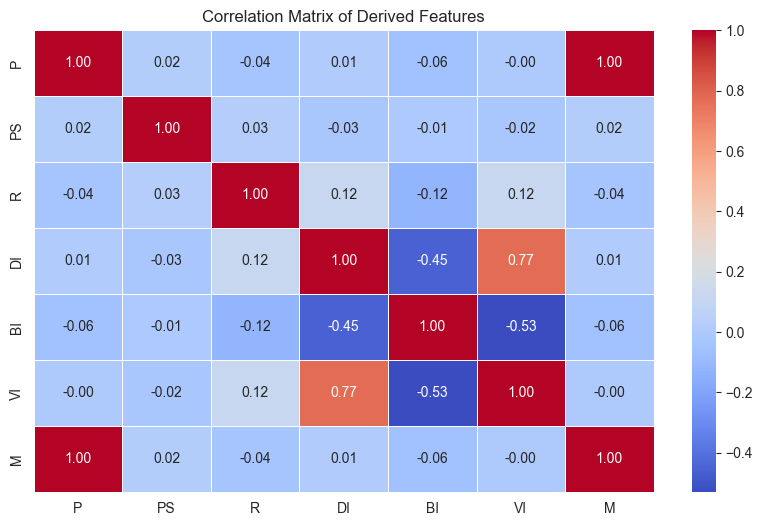

In [192]:
def plot_correlation_matrix(df):
    plt.figure(figsize=(10, 6))
    corr_matrix = df.corr()
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Correlation Matrix of Derived Features")
    plt.show()

plot_correlation_matrix(df_fe.drop(columns=['timestamp', 'd']))

In [193]:
def label_data(df, alpha):
    df = df.copy()
    df['y'] = np.where(df['d'] > alpha, 1, np.where(df['d'] < -alpha, -1, 0))
    return df

def plot_label_distribution(df):
    label_counts = df['y'].value_counts()
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'width_ratios': [1, 1]})
    
    sns.barplot(ax=axes[0], x=label_counts.index, y=label_counts.values, hue=label_counts.index, palette="viridis", dodge=False)
    axes[0].set_title('Class Distribution of Labels')
    axes[0].set_xlabel('Class Labels')
    axes[0].set_ylabel('Frequency')
    axes[0].legend(title="Labels", loc="upper right")
    
    sns.kdeplot(ax=axes[1], data=df, x='y', fill=True, alpha=0.5)
    axes[1].set_title('KDE Plot of Label Density')
    axes[1].set_xlabel('Class Labels')
    axes[1].set_ylabel('Density')
    
    plt.tight_layout()
    plt.show()

In [194]:
import numpy as np
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args

best_alpha = None
best_imbalance_ratio = float('inf')

BIG_NUM = 1e10
NEUTRAL_PENALTY_WEIGHT = 0.15

def calculate_imbalance_ratio(label_counts):
    positive_count = label_counts.get(1, 0)
    negative_count = label_counts.get(-1, 0)
    neutral_count = label_counts.get(0, 0)
    total_count = positive_count + negative_count + neutral_count
    
    if total_count == 0:
        return BIG_NUM

    weight_pos = positive_count / total_count
    weight_neg = negative_count / total_count
    weight_neutral = neutral_count / total_count
    
    neutral_penalty = weight_neutral ** 2

    if positive_count == 0 or negative_count == 0:
        balance_penalty = BIG_NUM
    else:
        balance_penalty = (abs(weight_pos - weight_neg)) ** 2
    
    return min(balance_penalty + NEUTRAL_PENALTY_WEIGHT * neutral_penalty, BIG_NUM)

search_space = [Real(1e-6, 1e-2, "log-uniform", name="alpha")]

@use_named_args(search_space)
def optimize_alpha(alpha):
    df_l = label_data(df_fe, alpha)
    label_counts = df_l['y'].value_counts()
    imbalance_ratio = calculate_imbalance_ratio(label_counts)
    
    if np.isinf(imbalance_ratio) or np.isnan(imbalance_ratio):
        imbalance_ratio = BIG_NUM

    return imbalance_ratio

result = gp_minimize(
    func=optimize_alpha,
    dimensions=search_space,
    n_calls=50,
    n_random_starts=5,
    acq_func="EI",
    random_state=seed
)

best_alpha = result.x[0]
best_imbalance_ratio = result.fun

print(f"Best alpha: {best_alpha}")
print(f"Best imbalance ratio: {best_imbalance_ratio}")

/Users/siarheimelnik/Projects/quant-prod/.venv/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [1e-06] before, using random point [0.0021710546456307923]
  warnings.warn(


Best alpha: 2.4982454193107785e-05
Best imbalance ratio: 0.005080530842449141


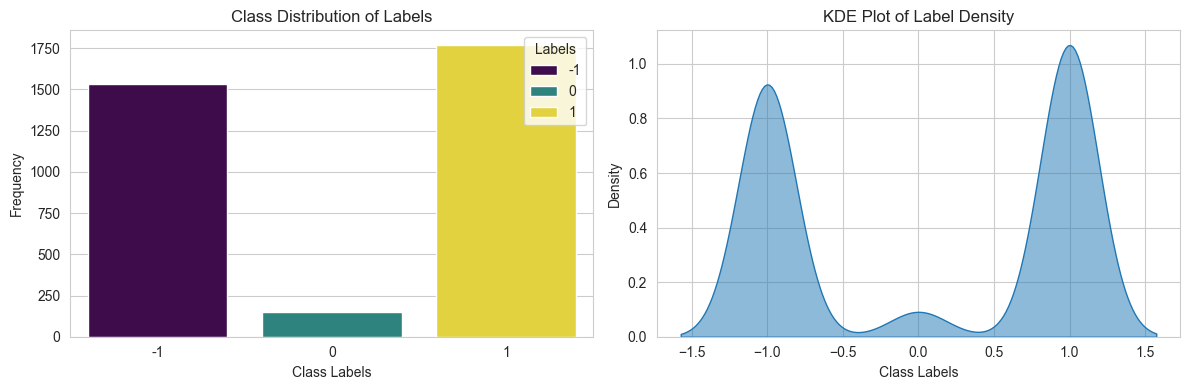

In [195]:
df_l = label_data(df_fe, best_alpha)

plot_label_distribution(df_l)

In [196]:
k = 10
EPS = np.finfo(float).eps

def normalize(X, y, features):
    X_normalized = X.copy()

    for col in features:
        rolling_mean = X[col].rolling(window=k).mean()
        rolling_std = X[col].rolling(window=k).std()
        X_normalized[col] = (X[col] - rolling_mean) / (rolling_std + EPS)

    X_normalized = X_normalized.dropna()
    y = y.loc[X_normalized.index]

    return X_normalized, y

In [197]:
from sklearn.calibration import expit, label_binarize
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, hamming_loss
from imblearn.under_sampling import NeighbourhoodCleaningRule

def sigmoid_fn(preds):
    m, c = np.polyfit(preds, np.log(preds / (1 - preds)), 1)
    return expit(m * preds + c)

def sigmoid_calibration(y_proba):
    return np.apply_along_axis(sigmoid_fn, 0, y_proba)

def isotonic_calibration(y_proba, y_test, classes):
    n_samples, n_classes = y_proba.shape
    calibrated_probs = np.zeros((n_samples, n_classes))
    y_binarized = label_binarize(y_test, classes=classes)

    for i, _ in enumerate(classes):
        class_preds = y_proba[:, i]
        calibrator = IsotonicRegression(out_of_bounds="clip")
        calibrator.fit(class_preds, y_binarized[:, i])
        calibrated_probs[:, i] = calibrator.predict(class_preds)

    return calibrated_probs

def venn_abers_calibration(y_proba, y_test, classes):
    n_samples, n_classes = y_proba.shape
    calibrated_probs = np.zeros((n_samples, n_classes))
    y_binarized = label_binarize(y_test, classes=classes)

    for i, _ in enumerate(classes):
        class_preds = y_proba[:, i]
        
        calibrator_lower = IsotonicRegression(out_of_bounds="clip")
        calibrator_lower.fit(class_preds, y_binarized[:, i])
        lower_bound = calibrator_lower.predict(class_preds)

        calibrator_upper = IsotonicRegression(out_of_bounds="clip")
        calibrator_upper.fit(1 - class_preds, 1 - y_binarized[:, i])
        upper_bound = 1 - calibrator_upper.predict(1 - class_preds)

        calibrated_probs[:, i] = np.sqrt(lower_bound * upper_bound)

    return calibrated_probs

def calibrate_probabilities(y_predict_proba, y_test, classes, calibration_method):
    if calibration_method == 'venn_abers':
        return venn_abers_calibration(y_predict_proba, y_test, classes)
    elif calibration_method == 'isotonic':
        return isotonic_calibration(y_predict_proba, y_test, classes)
    elif calibration_method == 'sigmoid':
        return sigmoid_calibration(y_predict_proba)
    else:
        raise ValueError("Unsupported calibration method.")

def perform_kfold_cv(model, X, y, k_folds=5, calibration_method='venn_abers'):
    kf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=seed)
    classes = np.unique(y)
    probabilities = np.zeros((len(y), len(classes)))
    predictions = np.zeros(len(y))
    true_labels = np.zeros(len(y))

    for train_index, test_index in kf.split(X, y):
        X_train_full, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train_full, y_test = y.iloc[train_index], y.iloc[test_index]

        sampler = NeighbourhoodCleaningRule()

        X_train_sampled, y_train_sampled = sampler.fit_resample(X_train_full, y_train_full)

        model.fit(X_train_sampled, y_train_sampled)

        y_predict_proba = model.predict_proba(X_test)

        calibrated_probs = calibrate_probabilities(y_predict_proba, y_test, classes, calibration_method)

        predictions[test_index] = classes[np.argmax(calibrated_probs, axis=1)]
        probabilities[test_index] = calibrated_probs

        true_labels[test_index] = y_test.values

    return predictions, probabilities, true_labels

def calculate_metrics(predictions, probabilities, y_true):
    y_true_binarized = label_binarize(y_true, classes=np.unique(y_true))

    def brier_loss_calc(y_true, pred):
        return ((y_true - pred)**2).mean()

    accuracy = accuracy_score(y_true, predictions)
    precision = precision_score(y_true, predictions, average='weighted', zero_division=0)
    recall = recall_score(y_true, predictions, average='weighted', zero_division=0)
    f1 = f1_score(y_true, predictions, average='weighted', zero_division=0)
    brier = brier_loss_calc(y_true, predictions)
    roc_auc = roc_auc_score(y_true_binarized, probabilities, average='weighted', multi_class='ovr')
    hamming = hamming_loss(y_true, predictions)

    return accuracy, precision, recall, f1, brier, roc_auc, hamming

def plot_regime(df, model_name):
    plt.figure(figsize=(16, 8))

    plt.plot(df['timestamp'], df['P'], color='gray', alpha=0.5, label='Feature P')

    plt.fill_between(df['timestamp'], df['P'], where=(df['regime'] == 1), 
                    color='green', alpha=0.3, label='Long')
    plt.fill_between(df['timestamp'], df['P'], where=(df['regime'] == -1), 
                    color='red', alpha=0.3, label='Short')
    
    plt.fill_between(df['timestamp'], df['P'], where=(df['regime'] == 0), 
                    color='blue', alpha=0.3, label='Range')

    plt.title(f'({model_name}) P and Regime')
    plt.xlabel('TS')
    plt.ylabel('P')
    plt.legend()
    plt.grid()

    plt.show()

def plot_roc_auc(probabilities, true_labels):
    y_test_bin = label_binarize(true_labels,  classes=np.unique(true_labels))
    
    roc_auc = roc_auc_score(y_test_bin, probabilities, average='macro', multi_class='ovr')

    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    
    for i in range(y_test_bin.shape[1]):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], probabilities[:, i])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0

    plt.figure(figsize=(8, 5))
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC Curve')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

In [198]:
features = ['P', 'PS', 'R', 'DI', 'BI', 'VI', 'M']

X = df_l[features]
y = df_l['y']

X_normalized, y = normalize(X, y, features)

timestamps = pd.to_datetime(df_l.loc[X_normalized.index]['timestamp'])


Accuracy: 0.9172
Precision: 0.9210
Recall: 0.9172
F1 Score: 0.8981
Brier Score: 0.2065
ROC-AUC Score: 0.9839
Hamming: 0.0828


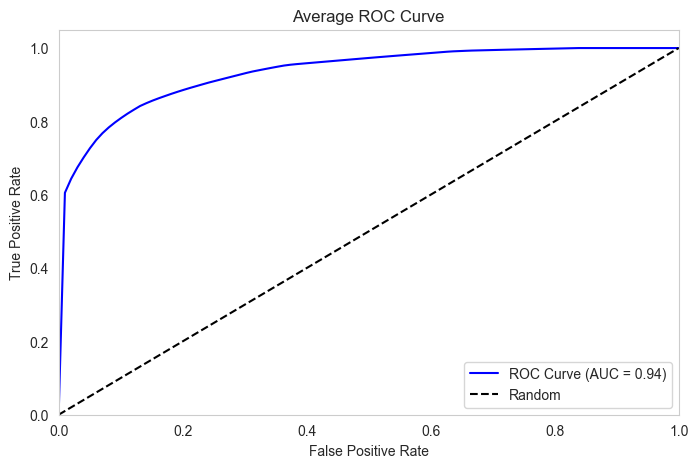

In [199]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

k_folds = 5
calibration = 'venn_abers'

model = OneVsRestClassifier(LogisticRegression(solver='saga', random_state=seed))

predictions, probabilities, true_labels = perform_kfold_cv(model, X_normalized, y, k_folds, calibration)

accuracy, precision, recall, f1, brier, roc_auc, hamming = calculate_metrics(predictions, probabilities, true_labels)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Brier Score: {brier:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")
print(f"Hamming: {hamming:.4f}")

plot_roc_auc(probabilities, true_labels)

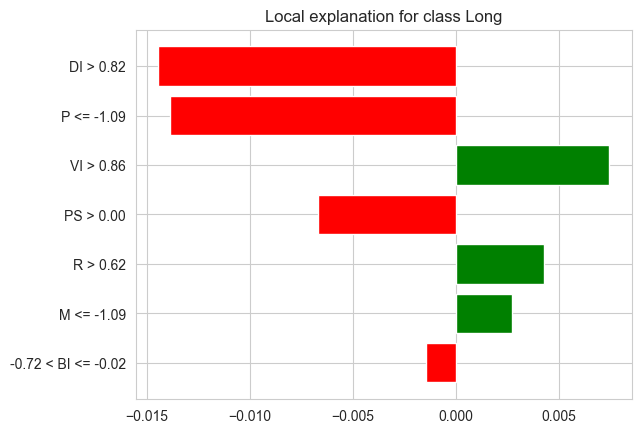

In [200]:
from lime.lime_tabular import LimeTabularExplainer

lime_explainer = LimeTabularExplainer(X_normalized.values, mode="classification", 
                                      feature_names=features, class_names=['Short', 'Long', 'Range'], 
                                      discretize_continuous=True)

def lime_predict_proba(data):
    data_df = pd.DataFrame(data, columns=features)
    return model.predict_proba(data_df)

random_index = np.random.randint(0, len(X_normalized))
exp = lime_explainer.explain_instance(X_normalized.iloc[random_index].values, lime_predict_proba, num_features=len(features))

exp.show_in_notebook(show_table=True)
exp.as_pyplot_figure()

plt.show()

In [201]:
from sklearn.ensemble import RandomForestClassifier

k_folds = 5

rf_model = RandomForestClassifier(random_state=seed)

perform_kfold_cv(rf_model, X_normalized, y, k_folds)

rf_imp = pd.DataFrame({
    "feature": X_normalized.columns,
    "importance": rf_model.feature_importances_
})

rf_imp = rf_imp.sort_values(by="importance", ascending=False).reset_index(drop=True)

rf_imp.head()

,feature,importance
0,M,0.459022
1,P,0.414172
2,R,0.045310
3,DI,0.022747
4,VI,0.022041


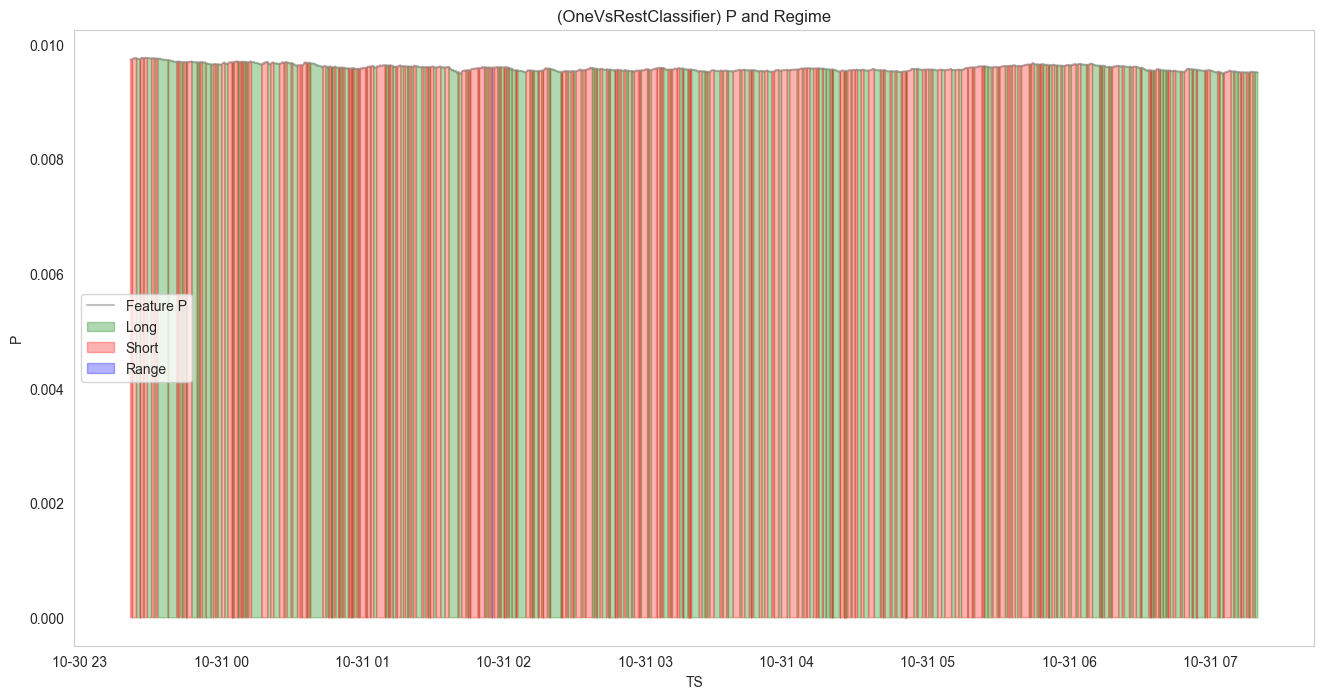

In [202]:
dpred = df_l.loc[X_normalized.index].copy()
dpred['regime'] = predictions

plot_regime(dpred, model.__class__.__name__)

In [203]:
def hawkes_intensity(t, mu, alpha, beta, event_times):
    time_diffs = t - event_times[event_times < t]
    return mu + torch.sum(alpha * torch.exp(-beta * time_diffs))

In [204]:
def create_prob_edge_index(event_times, mu=0.1, alpha=0.5, beta=1.0, sigmoid_scaling=1.0):
    edge_list, edge_weights = [], []
    n = len(event_times)
    
    intensities = torch.tensor([hawkes_intensity(event_times[i], mu, alpha, beta, event_times[:i]) for i in range(n)])
    probabilities = 1 / (1 + torch.exp(-sigmoid_scaling * intensities)).unsqueeze(1)
    selected_edges = torch.rand(n, n) < probabilities
    
    for i in range(n):
        for j in range(n):
            if i != j and selected_edges[i, j]:
                edge_list.append((i, j))
                edge_weights.append(probabilities[i, 0].item())
    
    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_weights, dtype=torch.float)
    
    return edge_index, edge_attr

In [205]:
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

BATCH_SIZE = 16
TEST_RATIO = 0.2

event_times = torch.tensor(timestamps.to_numpy().astype(float) // 10**9, dtype=torch.float)
y_mapped = y.replace({0: 0, -1: 1, 1: 2})

sampler = NeighbourhoodCleaningRule()
X_sampled, y_sampled = sampler.fit_resample(X_normalized.to_numpy(), y_mapped.values)
event_times_sampled = event_times[sampler.sample_indices_]

X_t = torch.tensor(X_sampled, dtype=torch.float)
y_t = torch.tensor(y_sampled, dtype=torch.long)

X_train, X_test, y_train, y_test, event_times_train, event_times_test = train_test_split(
    X_t, y_t, event_times_sampled, test_size=TEST_RATIO, random_state=seed, stratify=y_t
)

edge_index_train, edge_attr_train = create_prob_edge_index(event_times_train)
edge_index_test, edge_attr_test = create_prob_edge_index(event_times_test)

data_train = Data(x=X_train, edge_index=edge_index_train, edge_attr=edge_attr_train, y=y_train)
data_test = Data(x=X_test, edge_index=edge_index_test, edge_attr=edge_attr_test, y=y_test)

train_loader = DataLoader([data_train], batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader([data_test], batch_size=BATCH_SIZE)

In [66]:
import torch
from torch_geometric.nn import GATConv
from torch import nn
import torch.nn.functional as F

class JumpDiffusionLayer(nn.Module):
    def __init__(self, jump_intensity, jump_scale, volatility=0.1, learnable=False):
        super(JumpDiffusionLayer, self).__init__()
        self.jump_intensity = nn.Parameter(torch.tensor(jump_intensity), requires_grad=learnable)
        self.jump_scale = nn.Parameter(torch.tensor(jump_scale), requires_grad=learnable)
        self.volatility = nn.Parameter(torch.tensor(volatility))

    def forward(self, x):
        high_low_range = x.max(dim=1).values - x.min(dim=1).values
        current_volatility = torch.sqrt(torch.mean(high_low_range ** 2) / (4 * torch.log(torch.tensor(2.0))))

        adj_jump_intensity = self.jump_intensity * current_volatility.item() / self.volatility.item()
        adj_jump_intensity = max(0, min(adj_jump_intensity, 1))
        
        jumps = torch.bernoulli(torch.full(x.shape, adj_jump_intensity, dtype=torch.float32)) * \
                torch.normal(0, self.jump_scale * self.volatility.item(), size=x.shape)

        return x + jumps * self.jump_intensity

class SelfAttentionPooling(nn.Module):
    def __init__(self, in_dim, heads=8, dropout=0.1):
        super(SelfAttentionPooling, self).__init__()
        self.att1 = nn.MultiheadAttention(embed_dim=in_dim, num_heads=heads, dropout=dropout)
        self.att2 = nn.MultiheadAttention(embed_dim=in_dim, num_heads=heads, dropout=dropout)

    def forward(self, x):
        x = x.permute(2, 0, 1)
        attn_output1, _ = self.att1(x, x, x)
        attn_output2, _ = self.att2(attn_output1, attn_output1, attn_output1)
        pooled_output = attn_output2.mean(dim=0)
        return pooled_output
    
    
class ORCA(nn.Module):
    def __init__(self, in_channels, conv_out_channels, gat_out_channels, gat_heads=4, gat_dropout=0.1, classes=3, dropout=0.3, jump_intensity=0.1, jump_scale=0.05):
        super(ORCA, self).__init__()

        self.conv_block1_1d = nn.Sequential(
            nn.Conv1d(in_channels, conv_out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(conv_out_channels),
            nn.ReLU()
        )
        self.conv_block2_1d = nn.Sequential(
            nn.Conv1d(conv_out_channels, conv_out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(conv_out_channels),
            nn.ReLU()
        )
        self.conv_block3_1d = nn.Sequential(
            nn.Conv1d(conv_out_channels, conv_out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(conv_out_channels),
            nn.ReLU()
        )

        self.residual_conv_1d = nn.Conv1d(in_channels, conv_out_channels, kernel_size=1)
    
        self.conv_block1_2d = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding=(1, 1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=conv_out_channels, kernel_size=(3, 3), padding=(1, 1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(conv_out_channels),
            nn.AdaptiveAvgPool2d((None, 1))
        )

        self.conv_block2_2d = nn.Sequential(
            nn.Conv2d(in_channels=conv_out_channels, out_channels=conv_out_channels, kernel_size=(1, 2), padding=(1, 1)),
            nn.Tanh(),
            nn.BatchNorm2d(conv_out_channels),
            nn.Conv2d(in_channels=conv_out_channels, out_channels=conv_out_channels, kernel_size=(3, 1)),
            nn.Tanh(),
            nn.BatchNorm2d(conv_out_channels),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.jump_diffusion = JumpDiffusionLayer(jump_intensity, jump_scale)
        
        self.att_pool = SelfAttentionPooling(conv_out_channels)

        self.gat1 = GATConv(conv_out_channels, gat_out_channels, heads=gat_heads, dropout=gat_dropout)
        self.gat2 = GATConv(gat_out_channels * gat_heads, gat_out_channels, heads=1, dropout=gat_dropout)

        self.dropout = nn.Dropout(dropout)

        self.fc1 = nn.Linear(gat_out_channels, gat_out_channels // 2)
        self.fc2 = nn.Linear(gat_out_channels // 2, classes)

    def forward(self, x, edge_index, edge_attr):
        x = x.unsqueeze(1).transpose(1, 2)

        residual_1d = self.residual_conv_1d(x)

        x1d = self.conv_block1_1d(x)
        x1d = self.conv_block2_1d(x1d) + residual_1d
        x1d = self.conv_block3_1d(x1d)

        x1d = self.jump_diffusion(x1d)
    
        x1d = self.att_pool(x1d)

        x1d = x1d.unsqueeze(1).unsqueeze(-1)

        x2d = self.conv_block1_2d(x1d)
        x2d = self.conv_block2_2d(x2d)

        x2d = x2d.view(x2d.size(0), -1)

        x_gat = self.gat1(x2d, edge_index, edge_attr)
        x_gat = F.elu(self.gat2(x_gat, edge_index, edge_attr))

        x_gat = x_gat.view(x_gat.size(0), -1)

        x_gat = self.dropout(x_gat)
        x_gat = F.relu(self.fc1(x_gat))
        x_gat = self.fc2(x_gat)
        
        return x_gat

In [67]:
import torch.optim as optim

model = ORCA(in_channels=X_train.shape[1], conv_out_channels=32, gat_out_channels=16, gat_heads=8)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [68]:
epochs = 250

for epoch in range(epochs):
    model.train()

    train_loss = 0
    val_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()
  
        output = model(batch.x, batch.edge_index, batch.edge_attr)

        loss = criterion(output, batch.y)
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.item()

    model.eval()

    for batch in test_loader:
        output = model(batch.x, batch.edge_index, batch.edge_attr)
        loss = criterion(output, batch.y)
        val_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Train_Loss: {train_loss / len(train_loader):.4f}, Val_Loss: {val_loss / len(test_loader):.4f}")


KeyboardInterrupt: 